<a href="https://colab.research.google.com/github/Tekleab15/Optimizing-Neural-Networks-Implementing-Dropout-and-Dictionary-Learning/blob/main/Dictionary_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Visualize the Learned Dictionary Atoms**

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Load images in grayscale
def load_images(folder_path, img_size=(150, 150)):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, img_size).astype('float32') / 255.0
            images.append(img_resized)
        else:
            print(f"Failed to load image: {img_path}")
    return np.array(images)

In [ ]:
class_folder = '/content/drive/My Drive/Scene_dataset/seg_train/street/'
# Load images
images = load_images(class_folder)
print(f"Loaded {len(images)} images.")

In [ ]:
# 2. Extract patches with positions
def extract_patches_with_positions(images, patch_size=(8, 8), max_patches=100):
    patches = []
    positions = []
    for img_idx, img in enumerate(images):
        h, w = img.shape
        if h < patch_size[0] or w < patch_size[1]:
            continue  # Skip images smaller than patch size
        for _ in range(max_patches):
            y = np.random.randint(0, h - patch_size[0] + 1)
            x = np.random.randint(0, w - patch_size[1] + 1)
            patch = img[y:y+patch_size[0], x:x+patch_size[1]].flatten()
            patches.append(patch)
            positions.append((img_idx, y, x))
    return np.array(patches), positions

In [ ]:
patch_size = (8, 8)
max_patches = 100
patches, positions = extract_patches_with_positions(images, patch_size, max_patches)
print(f"Extracted {len(patches)} patches with positions.")

# 3. Initialize dictionary
def initialize_dictionary(patches, n_atoms):
    np.random.seed(42)
    idx = np.random.choice(len(patches), n_atoms, replace=False)
    D = patches[idx]
    D = D / (np.linalg.norm(D, axis=1, keepdims=True) + 1e-6)
    return D

n_atoms = 128
dictionary = initialize_dictionary(patches, n_atoms)

In [ ]:
# 4. Orthogonal Matching Pursuit (OMP)
def omp(D, x, sparsity):
    residual = x.copy()
    idxs = []
    alpha = np.zeros(D.shape[0])
    for _ in range(sparsity):
        projections = D @ residual
        idx = np.argmax(np.abs(projections))
        if idx in idxs:
            break
        idxs.append(idx)
        D_sub = D[idxs].T
        alpha_sub, _, _, _ = np.linalg.lstsq(D_sub, x, rcond=None)
        residual = x - D_sub @ alpha_sub
    alpha[idxs] = alpha_sub
    return alpha


In [ ]:
# 5. Dictionary Learning
def dictionary_learning(patches, n_atoms, sparsity, n_iter):
    D = initialize_dictionary(patches, n_atoms)
    for iteration in range(n_iter):
        print(f"Iteration {iteration+1}/{n_iter}")
        # Sparse coding step
        Alpha = np.array([omp(D, x, sparsity) for x in patches])
        # Dictionary update step
        for k in range(n_atoms):
            idxs = np.where(Alpha[:, k] != 0)[0]
            if len(idxs) == 0:
                continue
            E = patches[idxs] - Alpha[idxs] @ D + np.outer(Alpha[idxs, k], D[k])
            # Perform SVD on the error matrix
            U, S, Vt = np.linalg.svd(E, full_matrices=False)
            D[k] = Vt[0]
            D[k] /= np.linalg.norm(D[k]) + 1e-6
            Alpha[idxs, k] = S[0] * U[:, 0]
    return D, Alpha

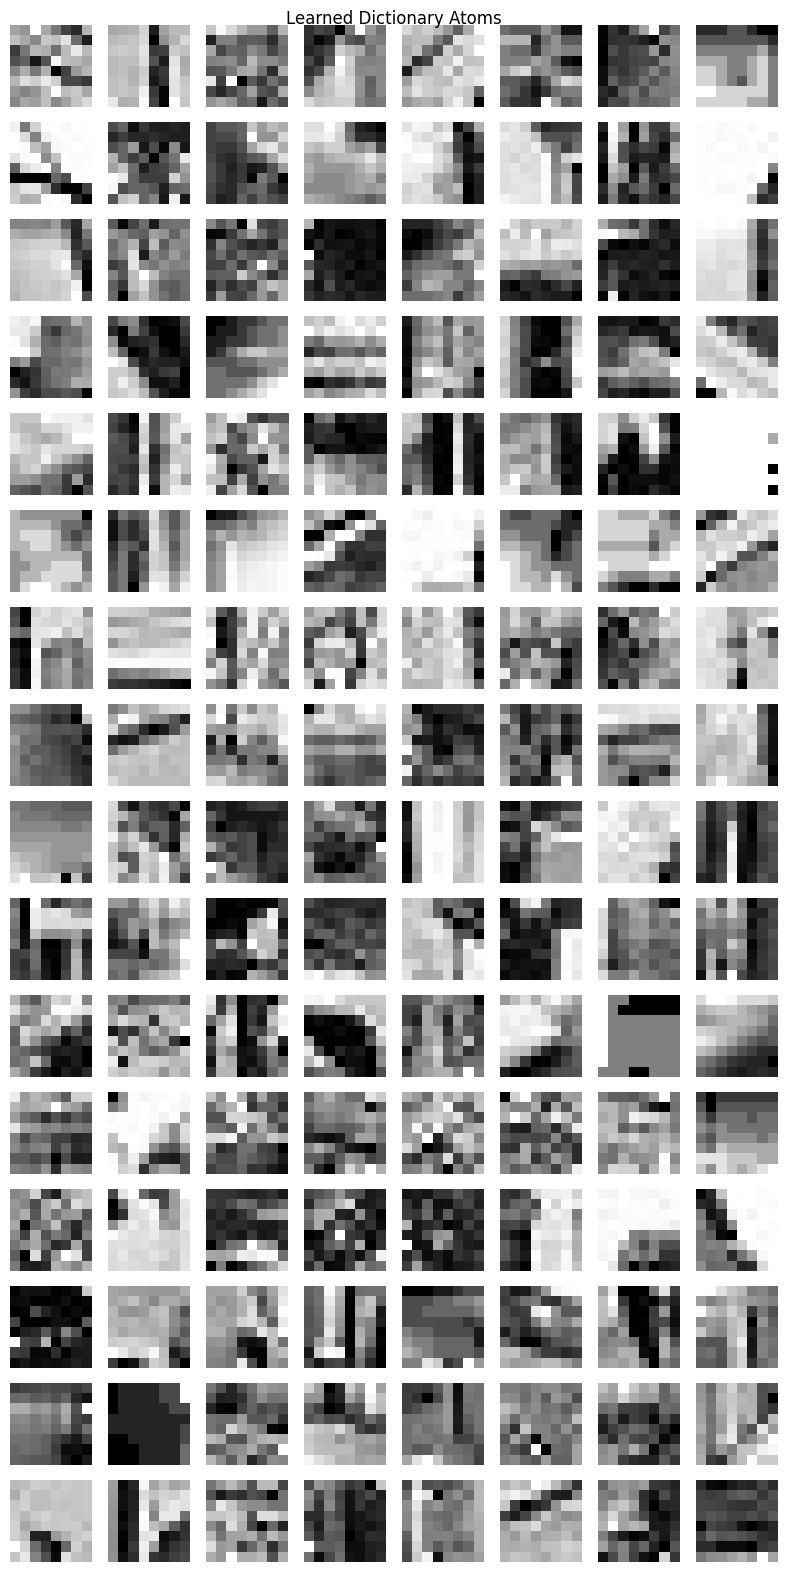

In [31]:
def plot_dictionary_atoms(dictionary, patch_size, n_cols=8):
    n_atoms = dictionary.shape[0]
    n_rows = (n_atoms + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols, n_rows))
    for i in range(n_atoms):
        atom = dictionary[i].reshape(patch_size)
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(atom, cmap='gray')
        plt.axis('off')
    plt.suptitle('Learned Dictionary Atoms')
    plt.tight_layout()
    plt.show()

n_atoms = 128
dictionary = initialize_dictionary(patches, n_atoms)
sparsity_level = 10
num_iterations = 10
patch_size = (8, 8)
plot_dictionary_atoms(dictionary, patch_size)

In [ ]:
n_atoms = 128
sparsity_level = 10
num_iterations = 10

# Perform dictionary learning
dictionary, sparse_codes = dictionary_learning(patches, n_atoms, sparsity_level, num_iterations)
print("Dictionary learning completed.")
# 6. Reconstruct patches
reconstructed_patches = np.dot(sparse_codes, dictionary)

# 7. Reconstruct images
num_images = len(images)
img_height, img_width = images[0].shape

reconstructed_images = np.zeros((num_images, img_height, img_width), dtype=np.float32)
overlap_counts = np.zeros((num_images, img_height, img_width), dtype=np.float32)

for idx, (img_idx, y, x) in enumerate(positions):
    patch = reconstructed_patches[idx].reshape(patch_size)
    reconstructed_images[img_idx, y:y+patch_size[0], x:x+patch_size[1]] += patch
    overlap_counts[img_idx, y:y+patch_size[0], x:x+patch_size[1]] += 1

# 8. Handle overlaps
overlap_counts[overlap_counts == 0] = 1
reconstructed_images /= overlap_counts

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded 2382 images.
Extracted 238200 patches with positions.
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Dictionary learning completed.
Mean Squared Reconstruction Error: 0.191581


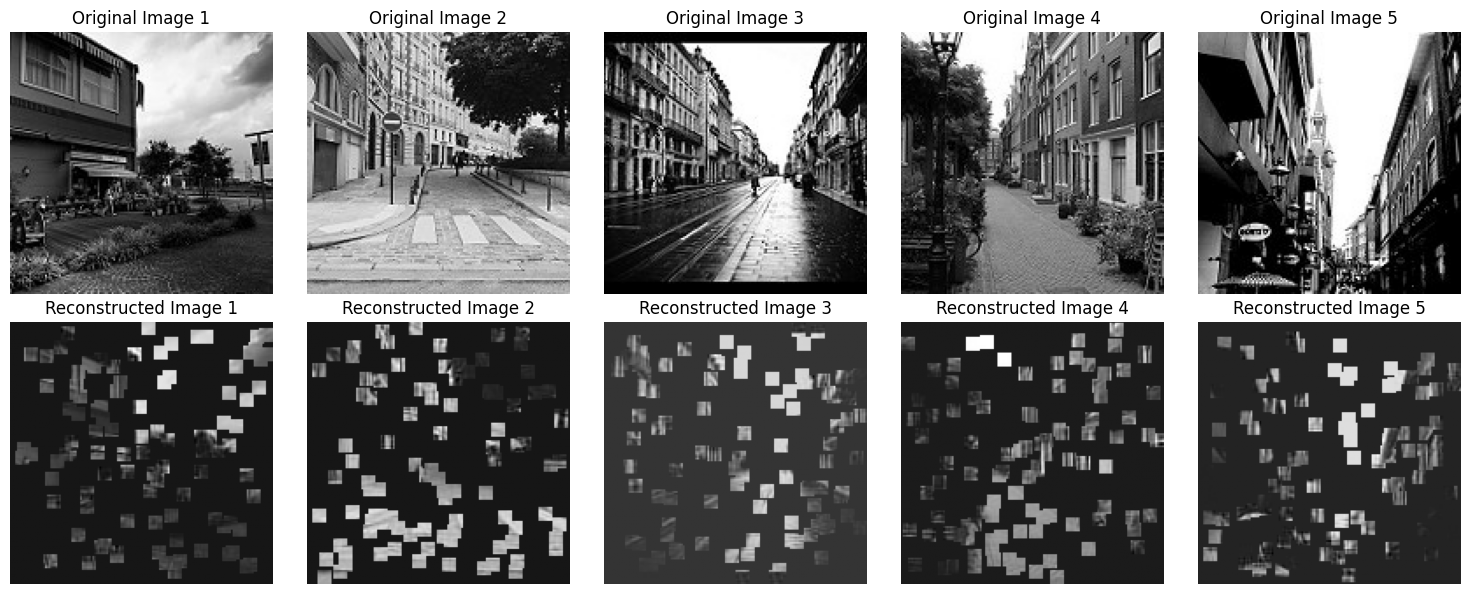

In [29]:
# 9. Compute reconstruction error
def compute_image_reconstruction_error(original_images, reconstructed_images):
    mse = np.mean((original_images - reconstructed_images) ** 2)
    print(f"Mean Squared Reconstruction Error: {mse:.6f}")

compute_image_reconstruction_error(images, reconstructed_images)

# 10. Visualize original vs. reconstructed images
def plot_original_vs_reconstructed(original_images, reconstructed_images, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(min(num_images, len(original_images))):
        # Original Image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i], cmap='gray')
        plt.title(f'Original Image {i+1}')
        plt.axis('off')
        # Reconstructed Image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(reconstructed_images[i], cmap='gray')
        plt.title(f'Reconstructed Image {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_original_vs_reconstructed(images, reconstructed_images)